# Different types of signals (keep track of this in the tables):
- 1-	eQTL signal map to a single gene and a single GWAS
- 2-	multiple traits, single gene
- 3-	multiple traits, multiple genes
- 4-	one trait, multiple genes


In [2]:
library(coloc)

In [3]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [25]:
dir.create("pipeline/eqtl.4.finemap_single"      , showWarnings = FALSE)
dir.create("pipeline/eqtl.4.finemap_single/input", showWarnings = FALSE)


In [5]:
exp_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")
qtl_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )


In [6]:
coordinates = exp_data[["coordinates"]]
gene_info   = coordinates[ coordinates$phenotype == "rna",]


In [7]:
coloc_gwas =              fread("pipeline/eqtl.2.gwas_coloc/coloc.txt"                      , sep = "\t", header = TRUE, data.table = FALSE)
manifest   = add_rownames(fread("pipeline/1.1.sumstats/manifest.txt"                        , sep = "\t", header = TRUE, data.table = FALSE))
#pph4       = coloc[ coloc$PP.H4.abf >= 0.8,]
loci       = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci.txt"      , sep = "\t", header = TRUE, data.table = FALSE))
loci2study = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci2study.txt", sep = "\t", header = TRUE, data.table = FALSE))


In [8]:
coloc_eqtl_list = list(isoform         = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.isoform.txt"      , sep = "\t", header = TRUE, data.table = FALSE),
                       gene            = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene.txt"         , sep = "\t", header = TRUE, data.table = FALSE),
                       isoform_vs_gene = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)
                      )

coloc_eqtl_list$isoform        $phenotype1 = "isoform"
coloc_eqtl_list$isoform        $phenotype2 = "isoform"
coloc_eqtl_list$gene           $phenotype1 = "gene"
coloc_eqtl_list$gene           $phenotype2 = "gene"
coloc_eqtl_list$isoform_vs_gene$phenotype1 = "gene"
coloc_eqtl_list$isoform_vs_gene$phenotype2 = "gene"

coloc_eqtl = as.data.frame(rbindlist(coloc_eqtl_list))
coloc_eqtl = merge(exp_data$coordinates[,c("transcript_id", "gene_id", "gene_name")], coloc_eqtl, by.x = "transcript_id", by.y = "transcript_id1")
coloc_eqtl = merge(exp_data$coordinates[,c("transcript_id", "gene_id", "gene_name")], coloc_eqtl, by.x = "transcript_id", by.y = "transcript_id2", suffixes = 1:2)

coloc_eqtl$transcript_id1 = coloc_eqtl$transcript_id
coloc_eqtl$transcript_id  = NULL
#coloc_eqtl = rbind(eqtl_coloc[["gene"]], eqtl_coloc[["isoform"]])


In [9]:
str(coloc_eqtl)

'data.frame':	464870 obs. of  25 variables:
 $ gene_id1      : chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" ...
 $ gene_name1    : chr  "DPM1" "SCYL3" "C1orf112" "CFH" ...
 $ transcript_id2: chr  "ENST00000371588.9_2" "ENST00000367771.11_4" "ENSG00000000457.14_7" "ENST00000367429.9_2" ...
 $ gene_id2      : chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000971.16_4" ...
 $ gene_name2    : chr  "DPM1" "SCYL3" "SCYL3" "CFH" ...
 $ nsnps         : int  2011 2835 2683 1293 1293 2493 2493 2493 2493 1957 ...
 $ PP.H0.abf     : num  3.94e-01 1.09e-02 1.33e-01 1.26e-06 1.87e-07 ...
 $ PP.H1.abf     : num  4.80e-01 3.02e-01 2.55e-01 3.59e-05 3.70e-05 ...
 $ PP.H2.abf     : num  0.04721 0.02097 0.15877 0.03396 0.00503 ...
 $ PP.H3.abf     : num  0.0576 0.582 0.3039 0.9649 0.9944 ...
 $ PP.H4.abf     : num  0.021105 0.084104 0.149402 0.001079 0.000569 ...
 $ type1         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ typ

# Get all associations for each locus
- locus --> traits --> genes/isoforms

In [10]:
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(colorspace))


In [11]:
coloc_gwas08 = coloc_gwas[ coloc_gwas$PP.H4.abf >= 0.8,]
coloc_eqtl08 = coloc_eqtl[ coloc_eqtl$PP.H4.abf >= 0.8,]


In [12]:
length(unique(coloc_gwas08$locus))

str(coloc_eqtl)

[1] 595

'data.frame':	464870 obs. of  25 variables:
 $ gene_id1      : chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" ...
 $ gene_name1    : chr  "DPM1" "SCYL3" "C1orf112" "CFH" ...
 $ transcript_id2: chr  "ENST00000371588.9_2" "ENST00000367771.11_4" "ENSG00000000457.14_7" "ENST00000367429.9_2" ...
 $ gene_id2      : chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000971.16_4" ...
 $ gene_name2    : chr  "DPM1" "SCYL3" "SCYL3" "CFH" ...
 $ nsnps         : int  2011 2835 2683 1293 1293 2493 2493 2493 2493 1957 ...
 $ PP.H0.abf     : num  3.94e-01 1.09e-02 1.33e-01 1.26e-06 1.87e-07 ...
 $ PP.H1.abf     : num  4.80e-01 3.02e-01 2.55e-01 3.59e-05 3.70e-05 ...
 $ PP.H2.abf     : num  0.04721 0.02097 0.15877 0.03396 0.00503 ...
 $ PP.H3.abf     : num  0.0576 0.582 0.3039 0.9649 0.9944 ...
 $ PP.H4.abf     : num  0.021105 0.084104 0.149402 0.001079 0.000569 ...
 $ type1         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ typ

In [13]:
get_assoc_by_locus = function(locus, loci, loci2study, coloc_gwas, coloc_eqtl)
{
    traits          = unlist(strsplit(loci[locus, "ids"], ","))
    coloc_gwas      = coloc_gwas[ coloc_gwas$locus == locus & coloc_gwas$gwas %in% traits,]
    transcript_ids  = sort(unique(coloc_gwas$transcript_id))
    coloc_eqtl      = coloc_eqtl[ coloc_eqtl$transcript_id1 %in% transcript_ids & coloc_eqtl$transcript_id2 %in% transcript_ids,]
    coloc_eqtl1     = coloc_eqtl[ coloc_eqtl$gene_id1 < coloc_eqtl$gene_id2,]
    coloc_eqtl2     = coloc_eqtl[ coloc_eqtl$gene_id1 > coloc_eqtl$gene_id2,]
    
    if(nrow(coloc_eqtl2) > 0)
    {
        my_heads    = c("transcript_id", "gene_id", "gene_name", "type", "pval", "phenotype")
        x = coloc_eqtl2
        coloc_eqtl2[,c(paste0(my_heads, 1), paste0(my_heads, 2))] = coloc_eqtl2[,c(paste0(my_heads, 2), paste0(my_heads, 1))]
        
        coloc_eqtl = rbind(coloc_eqtl1, coloc_eqtl2)
    }
    
    #return(coloc_eqtl[ coloc_eqtl$gene_name1 %in% c("THAP3", "ZBTB48") & coloc_eqtl$gene_name2 %in% c("THAP3", "ZBTB48") ,])
    
    gene_ids        = unique(coordinates[ coordinates$transcript_id %in% transcript_ids, c("gene_id", "gene_name")])
    coloc_gwas_08   = coloc_gwas[ coloc_gwas$PP.H4.abf >= 0.8,]
    coloc_eqtl_08   = coloc_eqtl[ coloc_eqtl$PP.H4.abf >= 0.8,]
    coloc_gwas_full = coloc_gwas
    coloc_eqtl_full = coloc_eqtl

    if(nrow(coloc_gwas) == 0){coloc_gwas = data.frame(gwas = character(), gene_id  = character(), gene_name  = character(),                                                   PP.H4.abf = numeric())}
    if(nrow(coloc_eqtl) == 0){coloc_eqtl = data.frame(                    gene_id1 = character(), gene_name1 = character(), gene_id2 = character(), gene_name2 = character(), PP.H4.abf = numeric())}
    
    if(nrow(coloc_gwas) > 0)
    {
        coloc_gwas_all = aggregate(PP.H4.abf ~ gwas + gene_id + gene_name, data = coloc_gwas, FUN = max)
        coloc_gwas_all = coloc_gwas_all[order(coloc_gwas_all$gwas, coloc_gwas_all$gene_id ),]
    }else
    {
        coloc_gwas_all = coloc_gwas[,c("gwas", "gene_id", "gene_name", "PP.H4.abf")]
    }
    
    if(nrow(coloc_eqtl) > 0)
    {
        coloc_eqtl_all = aggregate(PP.H4.abf ~ gene_id1 + gene_name1 + gene_id2 + gene_name2, data = coloc_eqtl, FUN = max)
        coloc_eqtl_all = coloc_eqtl_all[order(coloc_eqtl_all$gene_id1, coloc_eqtl_all$gene_id2),]
        coloc_eqtl_all = coloc_eqtl_all[ coloc_eqtl_all$gene_id1 != coloc_eqtl_all$gene_id2,]
    }else
    {
        coloc_eqtl_all = coloc_eqtl[,c("gene_id1", "gene_name1", "gene_id2", "gene_name2", "PP.H4.abf")]
    }
    
    if((nrow(coloc_gwas_all) > 0) & (nrow(coloc_eqtl_all) == 0))
    {
        coloc_eqtl_all = expand.grid(gene_ids$gene_id, gene_ids$gene_id)
        colnames(coloc_eqtl_all) = c("gene_id1", "gene_id2")
        coloc_eqtl_all           = merge(coloc_eqtl_all, gene_ids, by.x = "gene_id1", by.y = "gene_id")
        coloc_eqtl_all           = merge(coloc_eqtl_all, gene_ids, by.x = "gene_id2", by.y = "gene_id", suffixes = 1:2)
        coloc_eqtl_all$PP.H4.abf = 0
        
        coloc_eqtl_all = coloc_eqtl_all[,c("gene_id1", "gene_name1", "gene_id2", "gene_name2", "PP.H4.abf")]
        #coloc_eqtl_all = coloc_eqtl_all[coloc_eqtl_all$gene_id1 != coloc_eqtl_all$gene_id2,]
    }
    
    if((nrow(coloc_gwas_all) > 0) & (nrow(coloc_eqtl_all) > 0))
    {
        edges_gwas = merge(manifest[, c("id", "name")], coloc_gwas_all, by.x = "id", by.y = "gwas")
        edges_eqtl = coloc_eqtl_all
        
        colnames(edges_gwas) = c("id1", "name1", "id2", "name2", "weight")
        colnames(edges_eqtl) = c("id1", "name1", "id2", "name2", "weight")
        edges_gwas$type1     = "gwas"
        edges_gwas$type2     = "eqtl"
        edges_eqtl$type1     = "eqtl"
        edges_eqtl$type2     = "eqtl"
        edges_gwas$type      = "gwas_eqtl"
        edges_eqtl$type      = "eqtl_eqtl"
        nodes_gwas1          = edges_gwas[,c("id1", "name1", "type1")]
        nodes_gwas2          = edges_gwas[,c("id2", "name2", "type2")]
        nodes_eqtl1          = edges_eqtl[,c("id1", "name1", "type1")]
        nodes_eqtl2          = edges_eqtl[,c("id2", "name2", "type2")]
        
        colnames(nodes_gwas1) = c("id", "name", "type")
        colnames(nodes_gwas2) = c("id", "name", "type")
        colnames(nodes_eqtl1) = c("id", "name", "type")
        colnames(nodes_eqtl2) = c("id", "name", "type")
        
        edges         =        rbind(edges_gwas[,c("id1", "id2", "weight", "type")], edges_eqtl[,c("id1", "id2", "weight", "type")])
        edges$weight2 = unlist(lapply(edges$weight, function(x){ifelse(test = x >= 0.8, yes = 1, no = ifelse(test = x >= 0.5, yes = 0.1, no = 0))}))
        nodes         = unique(rbind(nodes_gwas1, nodes_gwas2, nodes_eqtl1, nodes_eqtl2))
        mynet         = graph_from_data_frame(d = edges[ edges$weight2 > 0,], vertices = nodes, directed = FALSE)

        #plot(mynet, 
        #     edge.width         = E(mynet)$weight2 * 10, 
        #     edge.color         = as.factor(E(mynet)$type), 
        #     vertex.shape       = "circle",
        #     vertex.label       = V(mynet)$name,
        #     vertex.color       = as.factor(V(mynet)$type),
        #     vertex.label.font  = 3
        #    )
        
        to_out = list(network = mynet, nodes = nodes, edges = edges)
    }
    else
    {
        to_out = list(network = NULL, nodes = NULL, edges = NULL)
    }
    
    
    #message(paste(locus, 
    #              paste("traits", length(traits), sep = " = "),
    #              paste("Traits that colocalize with eGenes", length(unique(coloc_gwas_all$gwas   )), sep = " = "),
    #              paste("eGenes that colocalize with traits", length(unique(coloc_gwas_all$gene_id)), sep = " = "),
    #              paste("eGenes that colocalize in locus"   , length(unique(c(as.matrix(unique(coloc_eqtl_all[ coloc_eqtl_all$gene_id1 %in% unique(coloc_gwas_all$gene_id) | coloc_eqtl_all$gene_id2 %in% unique(coloc_gwas_all$gene_id),c("gene_id1", "gene_id2")]))))), sep = " = "),
    #              sep = "\n"
    #             ))
    
    return(list(gwas            = traits, 
                gene_ids        = gene_ids,
                coloc_gwas_full = coloc_gwas_full[,grepl("interaction", colnames(coloc_gwas_full)) == FALSE], 
                coloc_eqtl_full = coloc_eqtl_full,
                coloc_gwas      = coloc_gwas_all, 
                coloc_eqtl      = coloc_eqtl_all,
                network         = to_out,
                summary         = data.frame(locus = locus, 
                                             traits = length(traits  ),
                                             egenes = nrow  (gene_ids),
                                             traits_eqtl = length(unique(coloc_gwas_all[ coloc_gwas_all$PP.H4.abf >= 0.8, "gwas"   ])),
                                             eqtl_traits = length(unique(coloc_gwas_all[ coloc_gwas_all$PP.H4.abf >= 0.8, "gene_id"])),
                                             eqtl_eqtl   = length(unique(c(as.matrix(unique(coloc_eqtl_all[ coloc_eqtl_all$PP.H4.abf >= 0.8 & coloc_eqtl_all$gene_id1 %in% unique(coloc_gwas_all$gene_id) | coloc_eqtl_all$gene_id2 %in% unique(coloc_gwas_all$gene_id),c("gene_id1", "gene_id2")])))))
                                            )
               ))
}

locus = "4_15928866_16137084"
#locus = "14_64512858_64914311"
#locus = "1_2592477_2853372"
#get_assoc_by_locus(locus, loci, loci2study, coloc_gwas, coloc_eqtl)

locus2coloc_list        = lapply(loci$locus, function(locus){get_assoc_by_locus(locus, loci, loci2study, coloc_gwas, coloc_eqtl)})
names(locus2coloc_list) = loci$locus



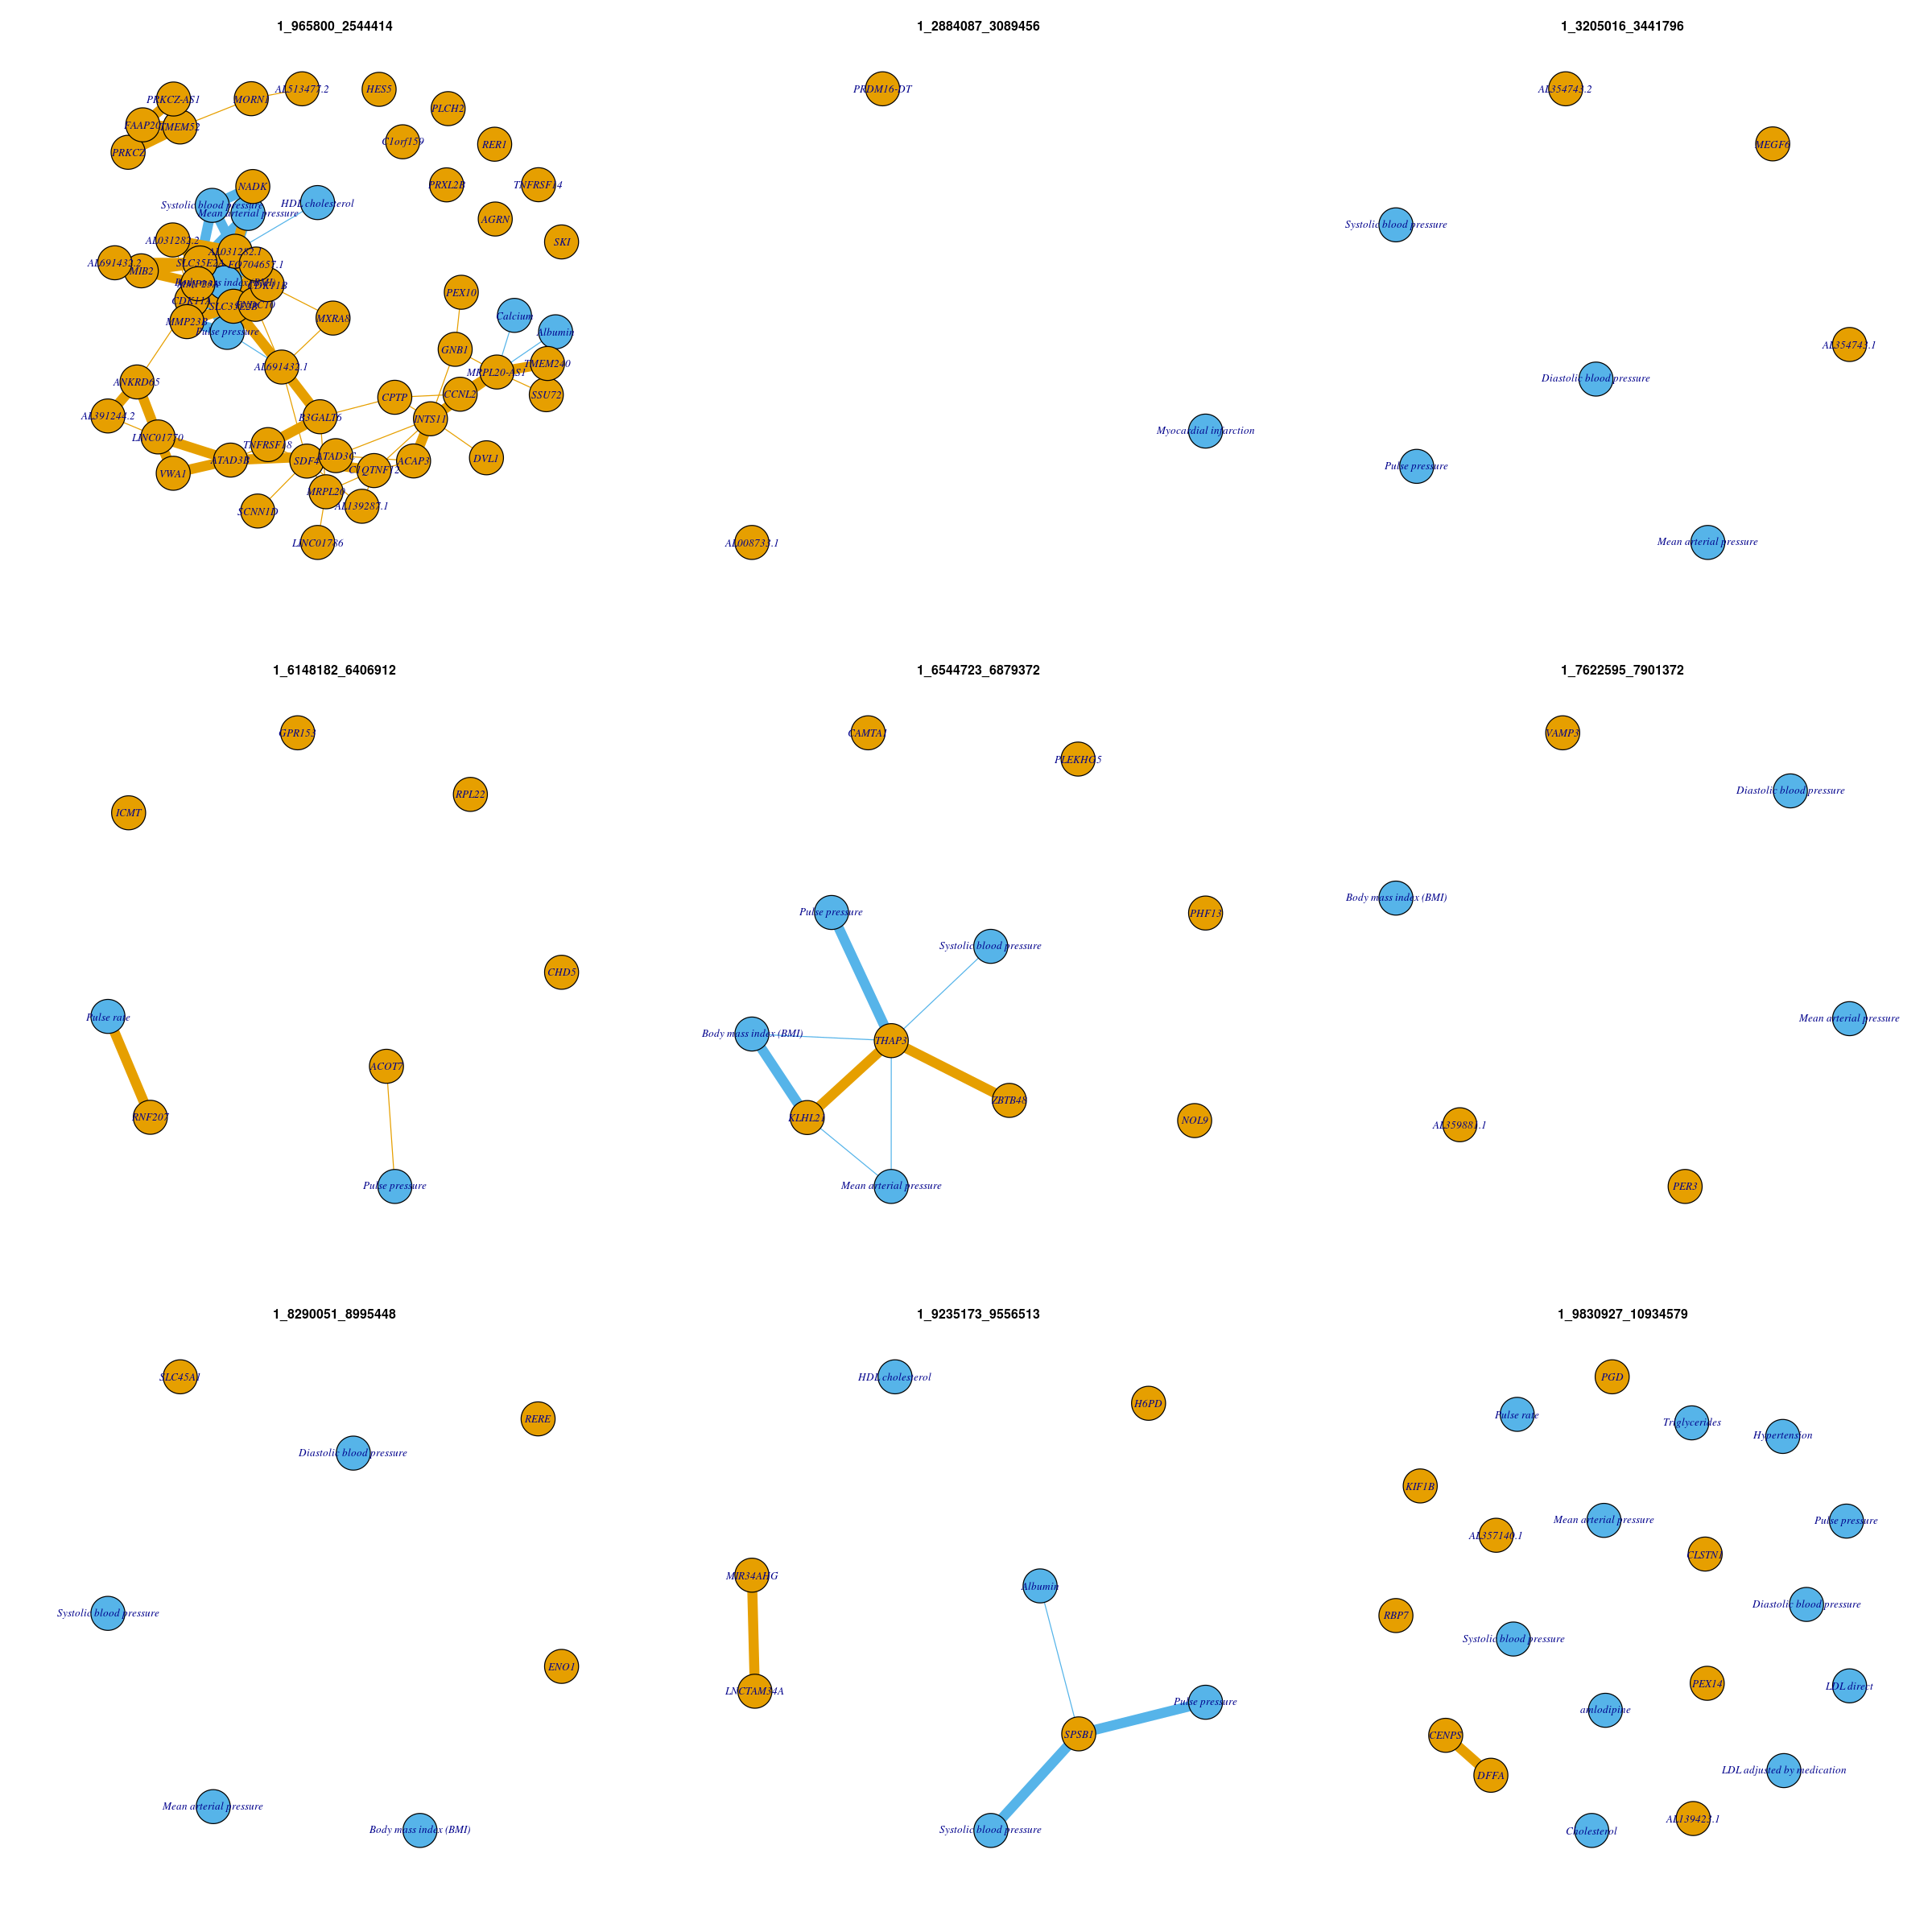

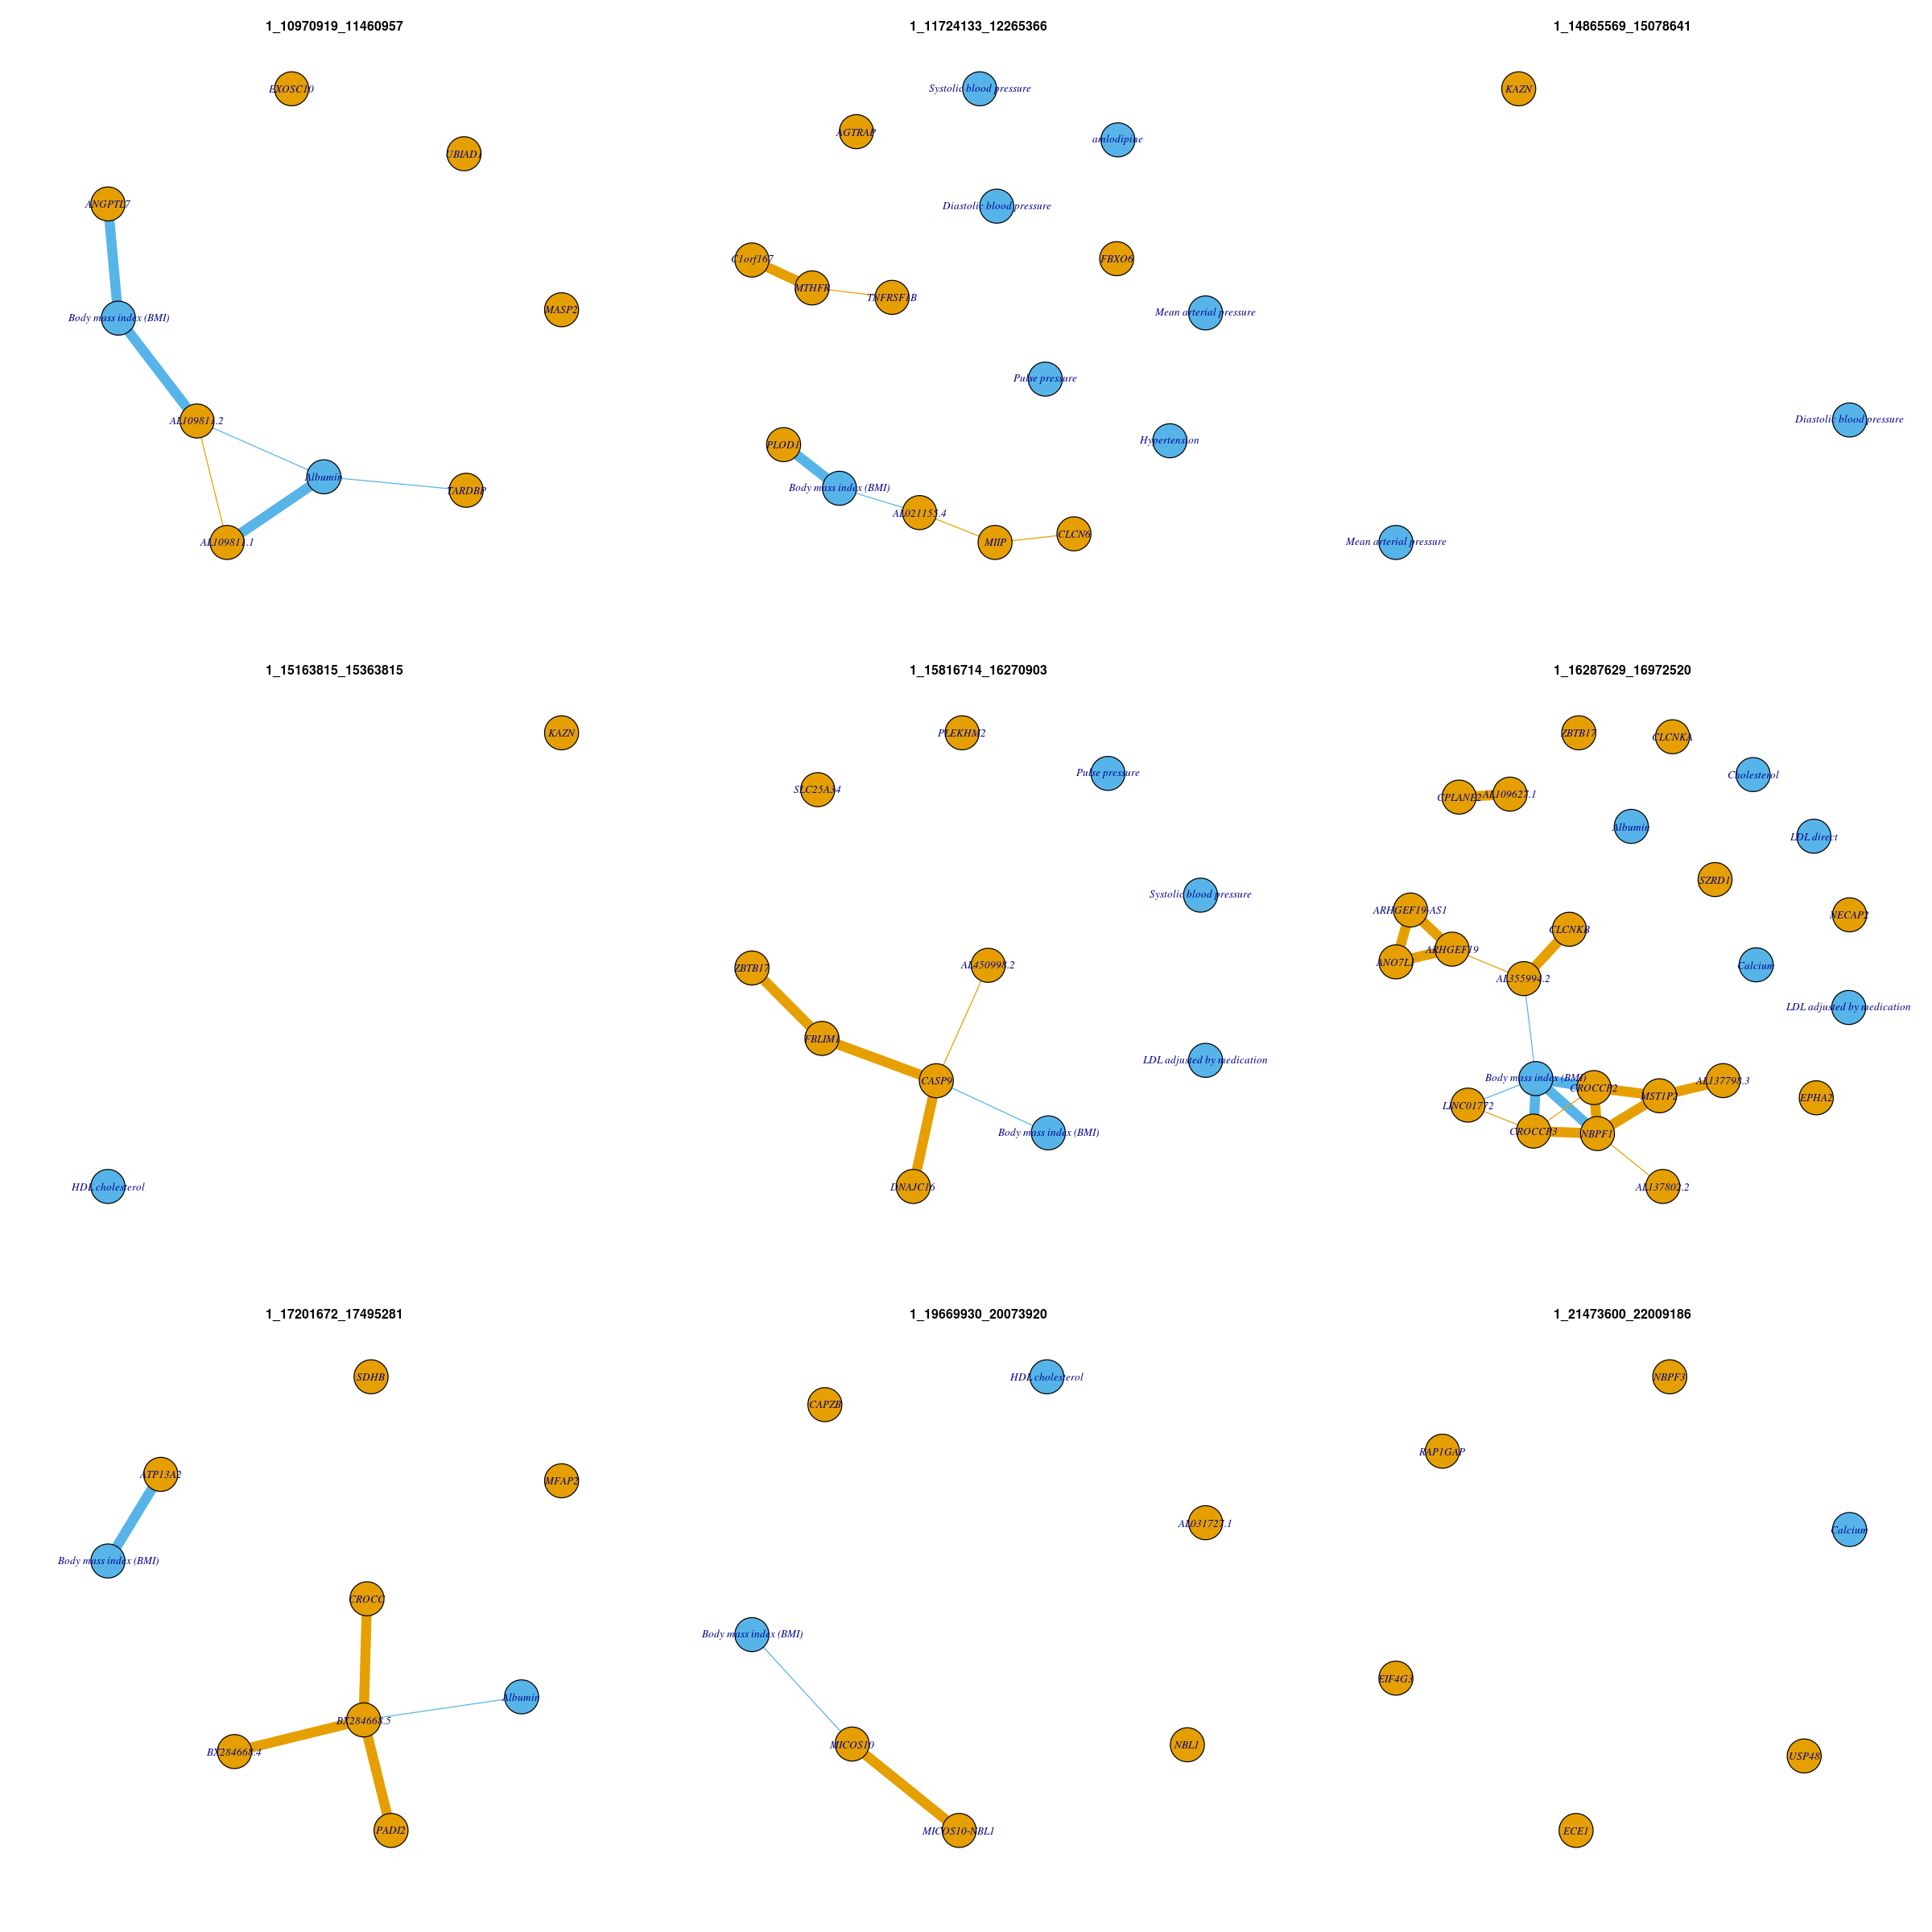

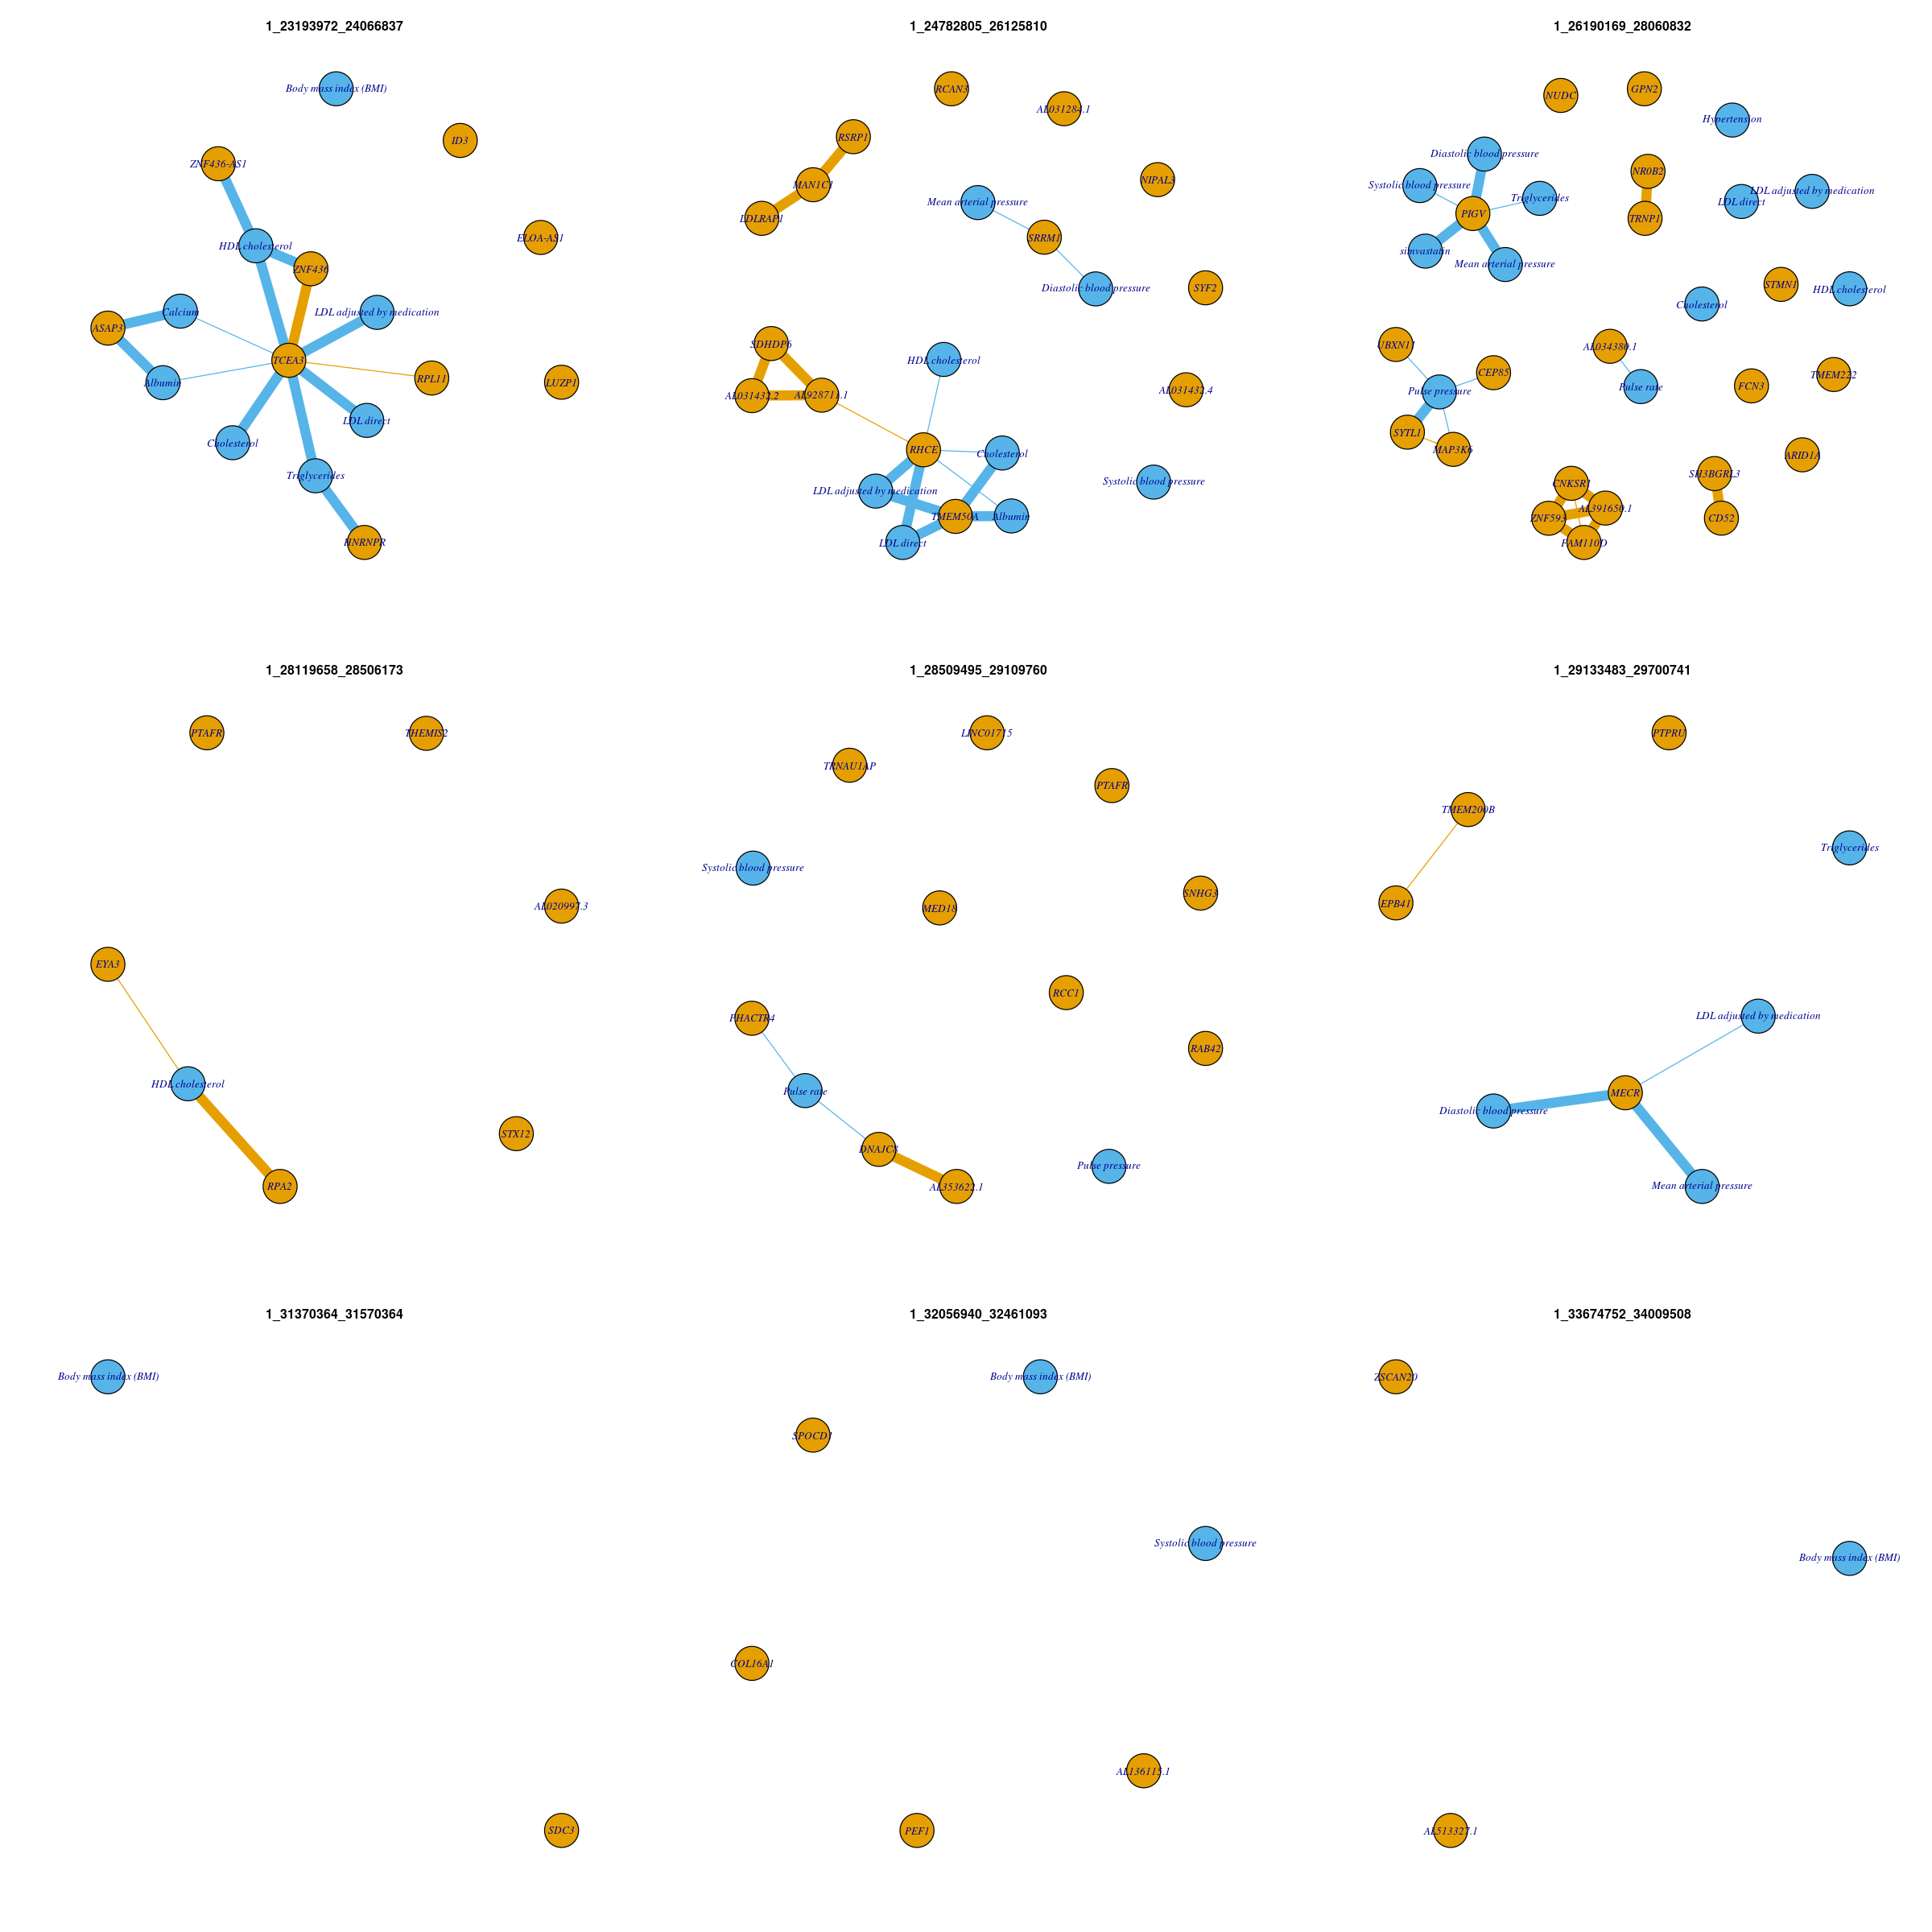

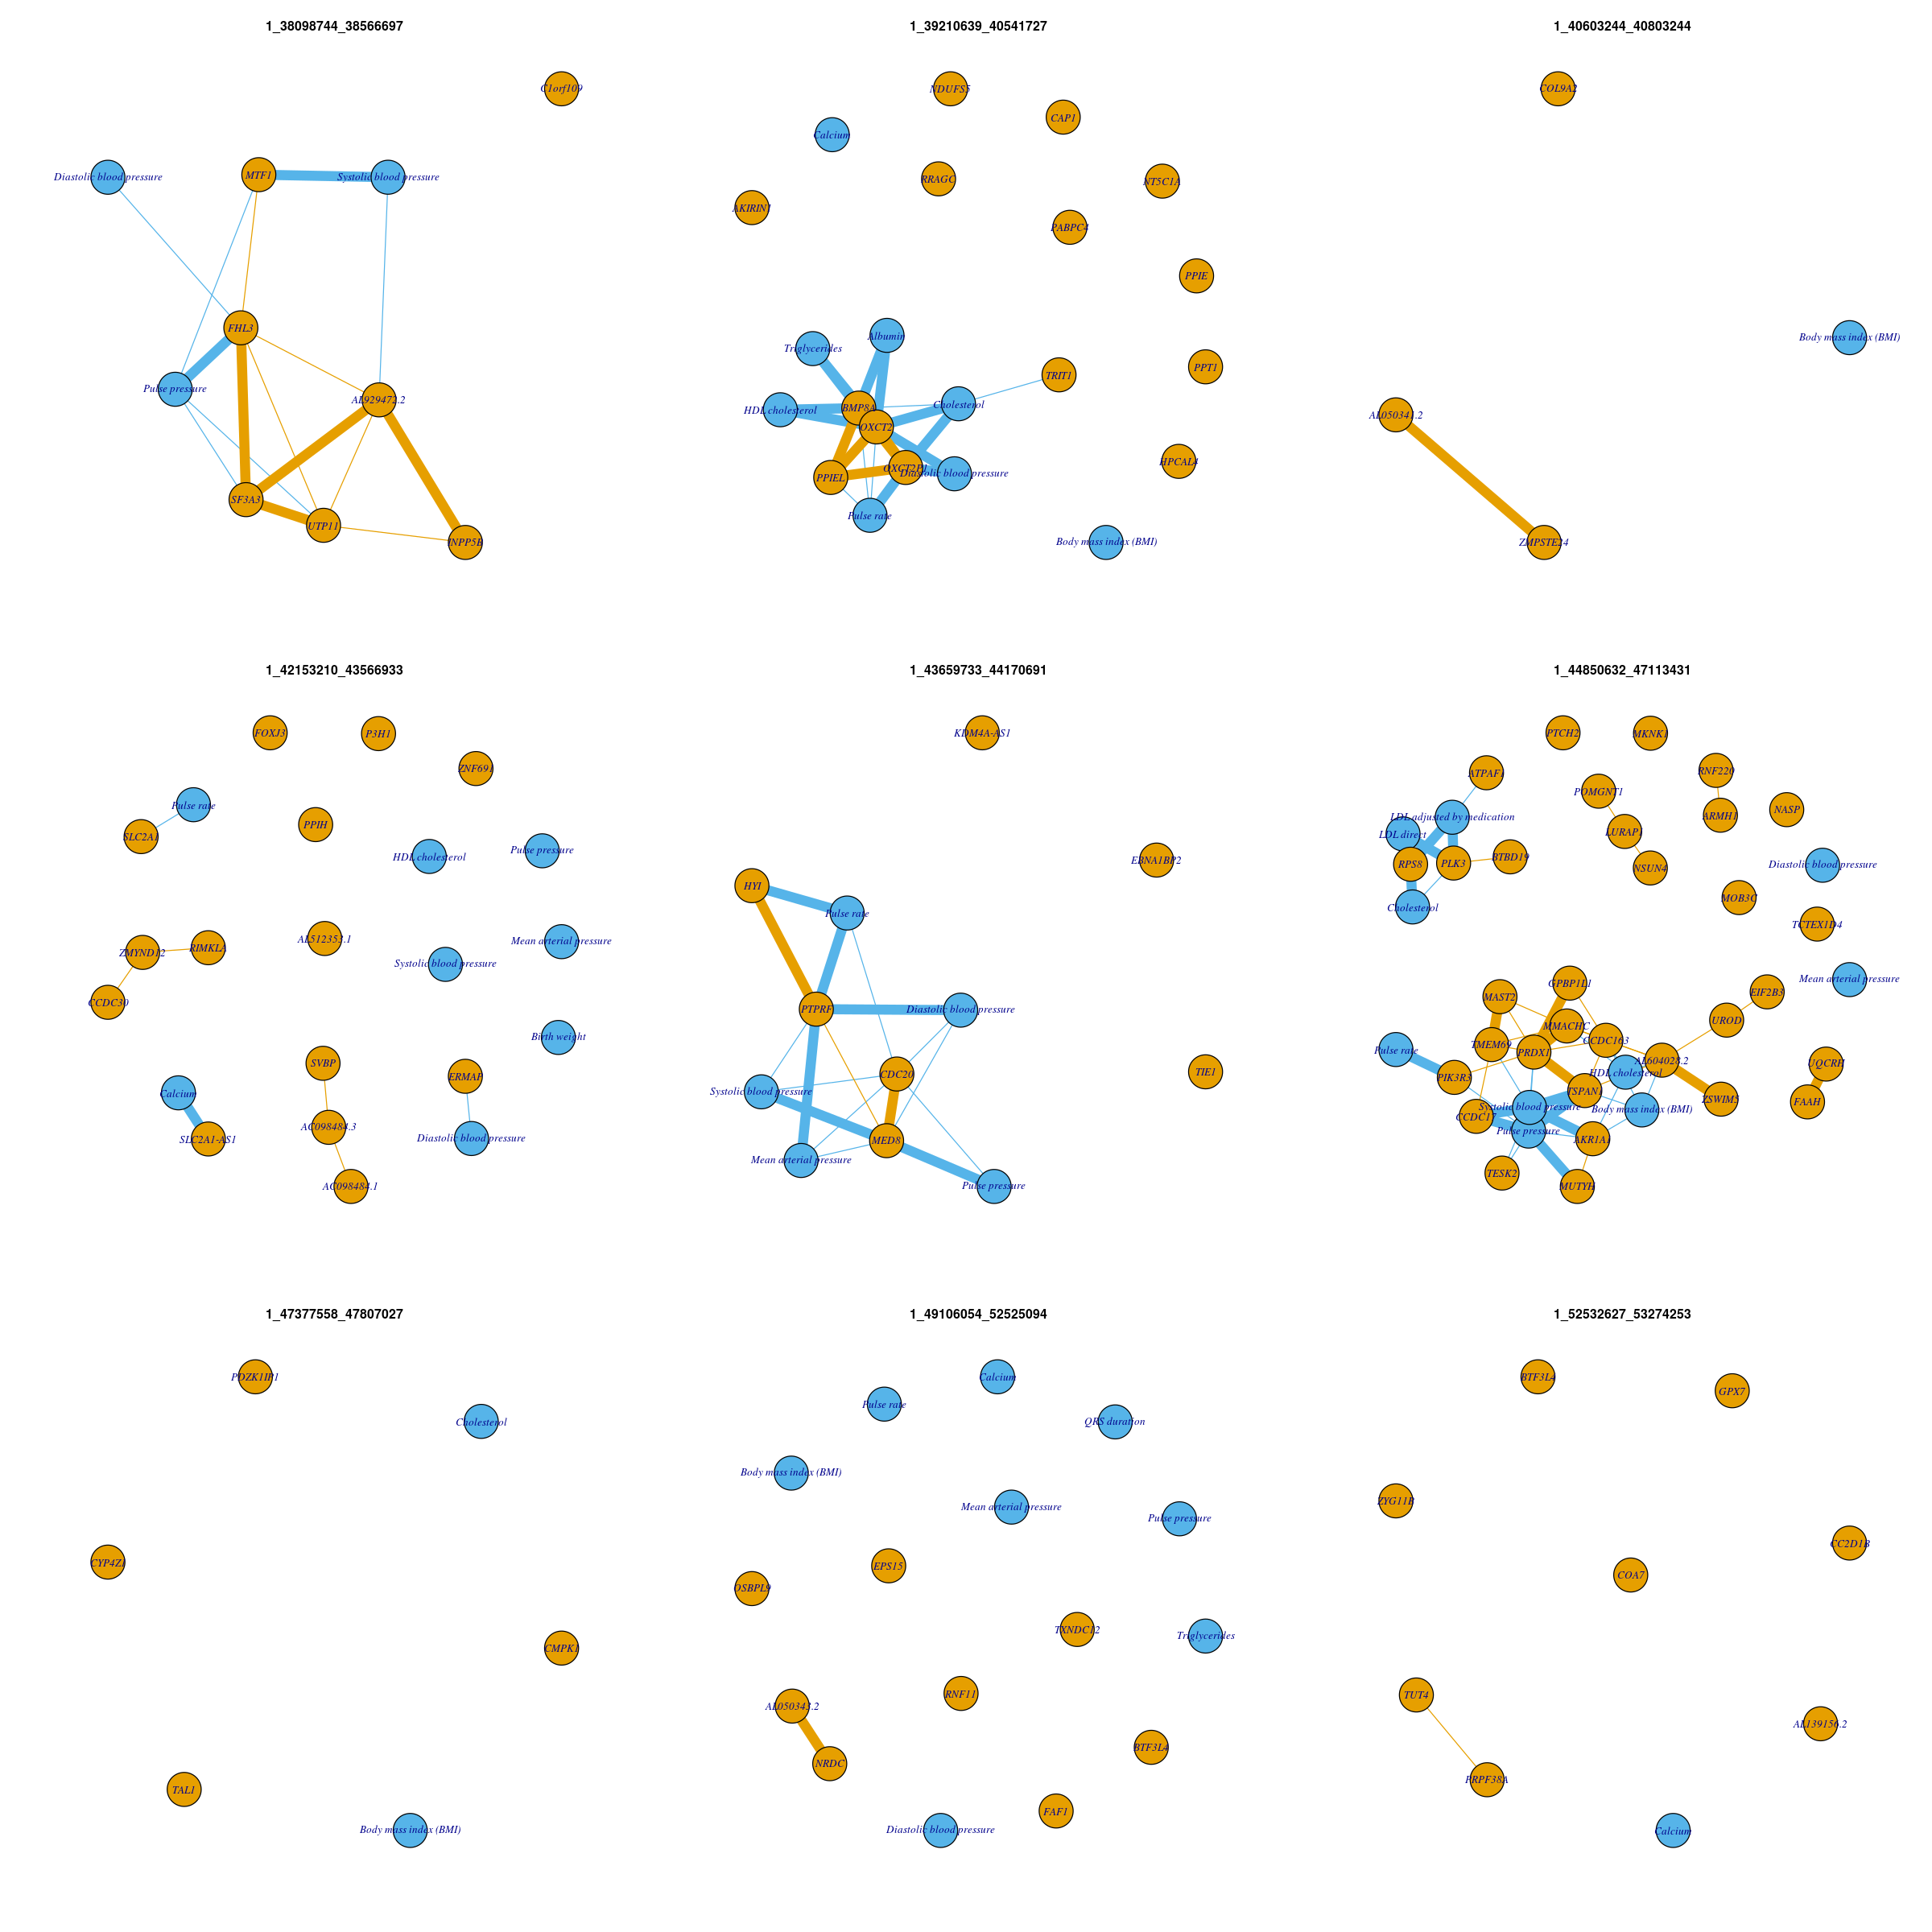

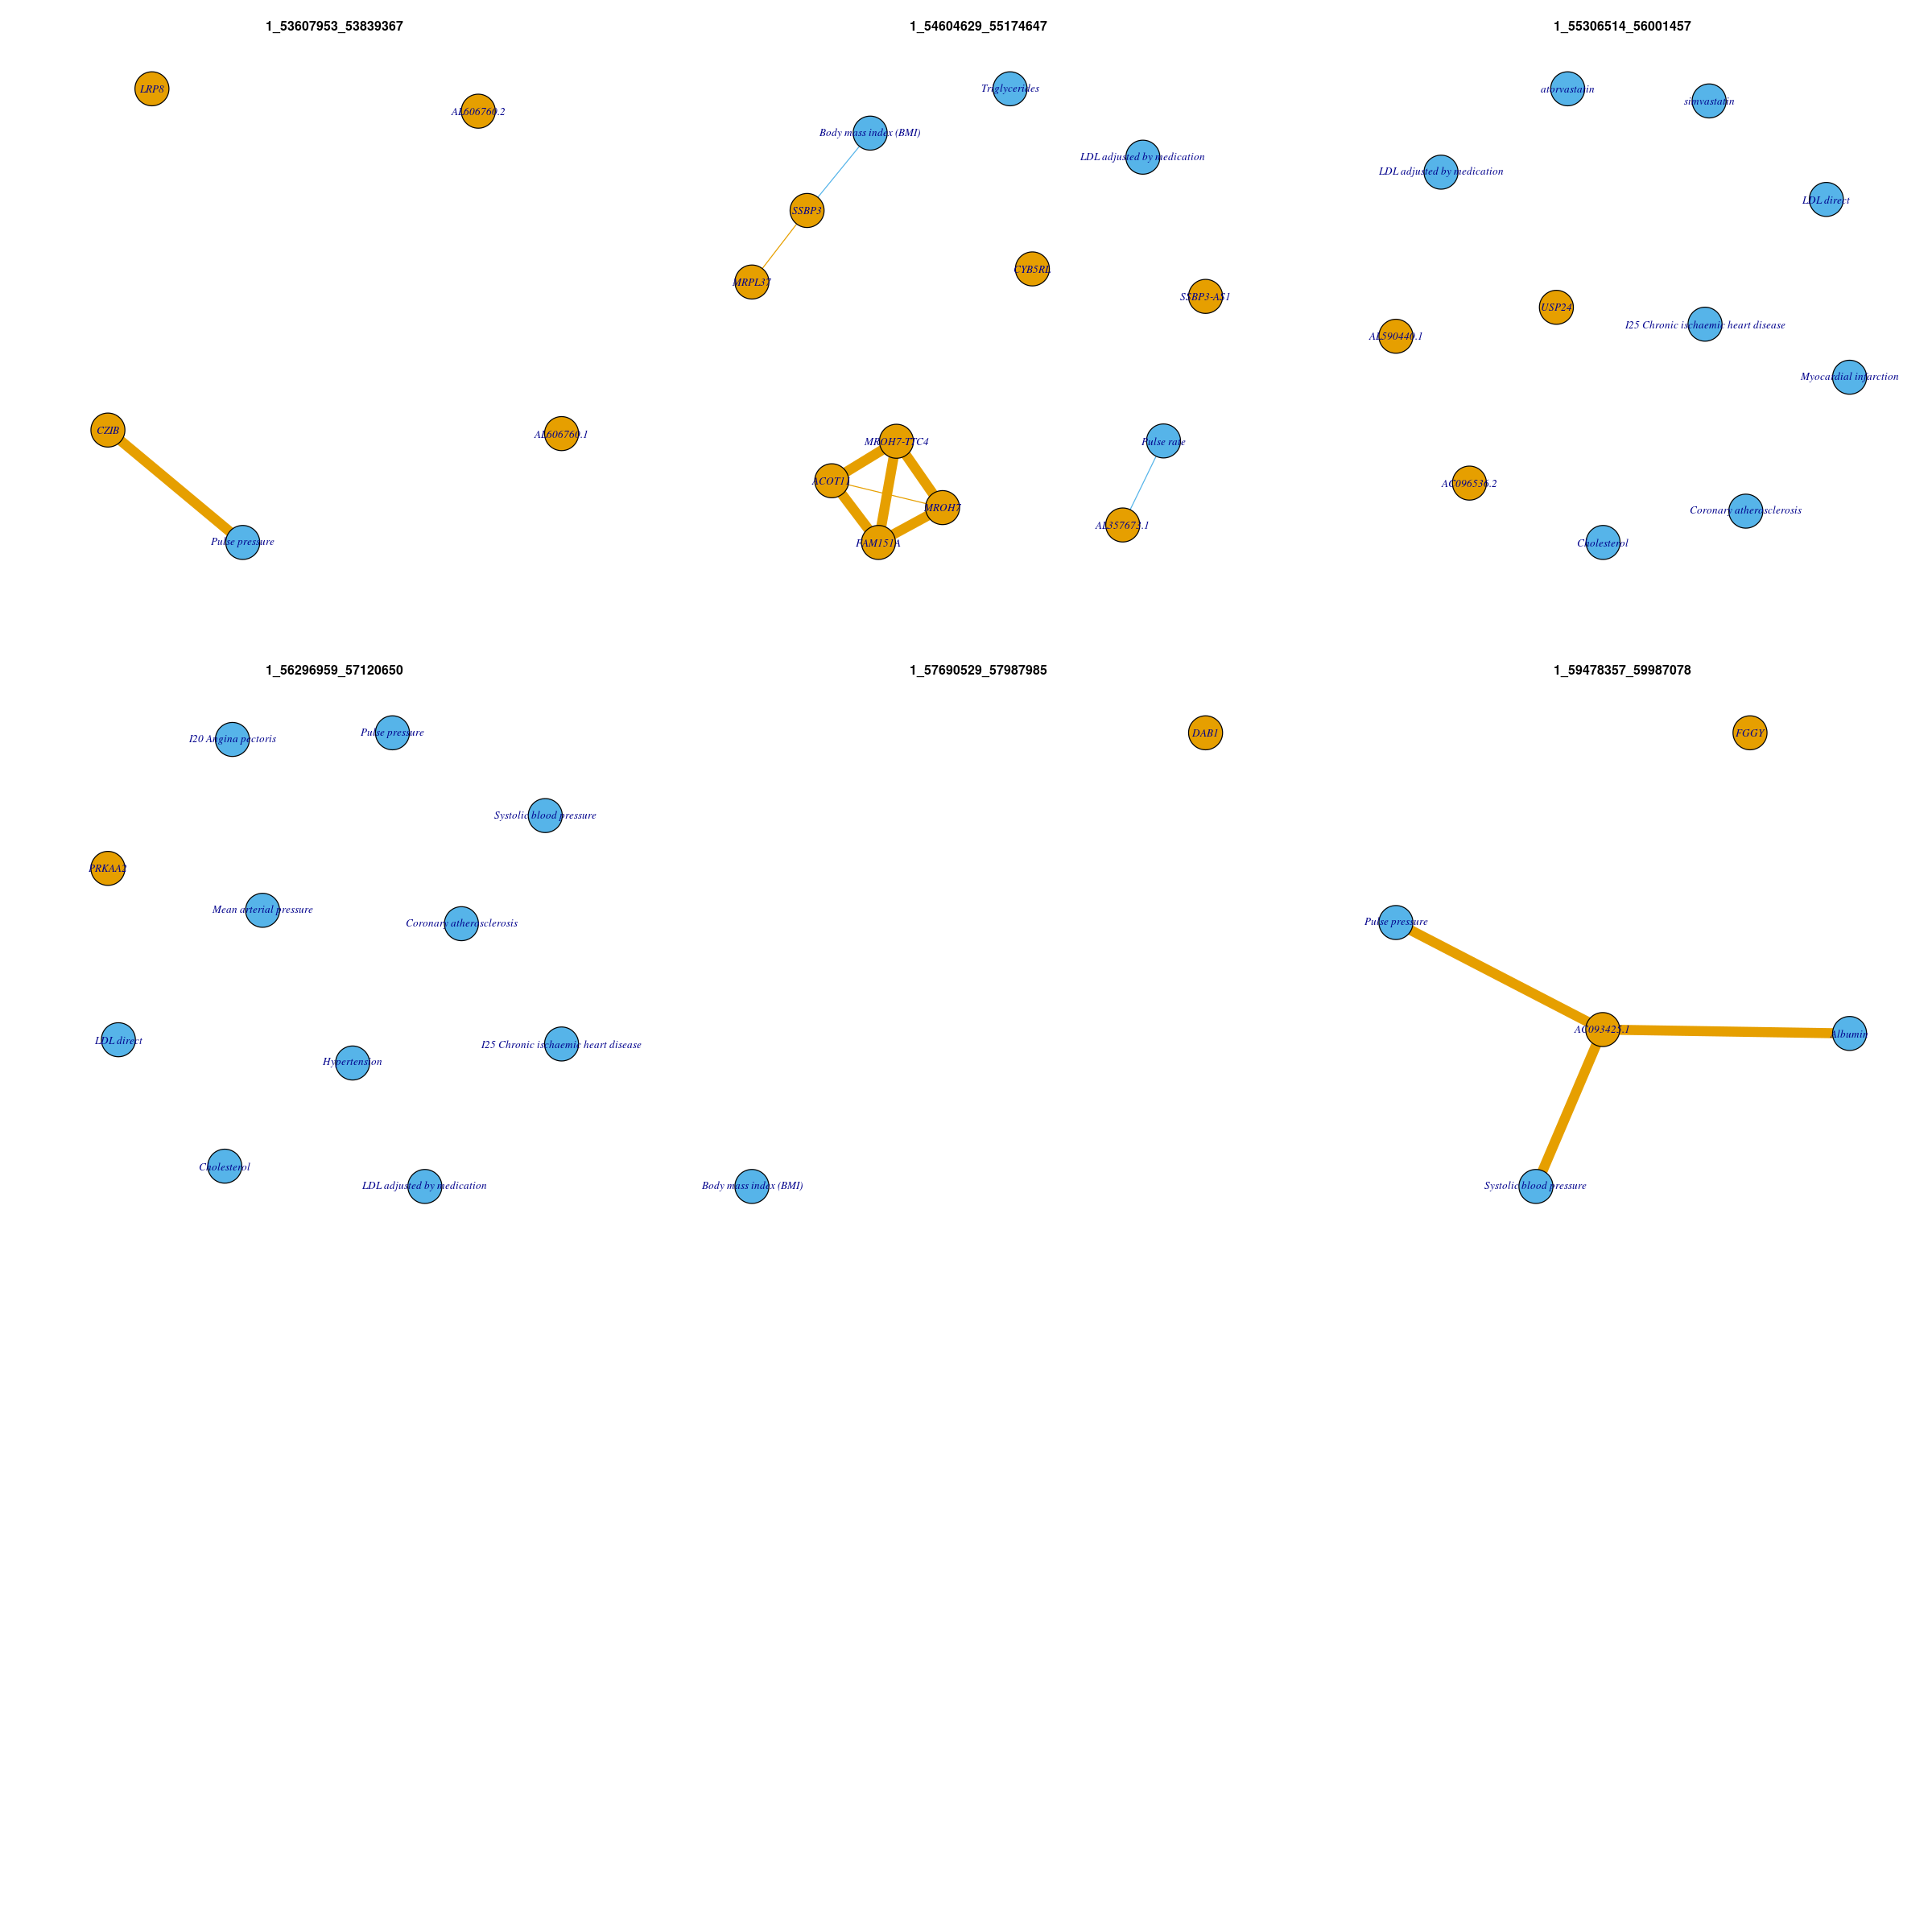

In [14]:
options(repr.plot.width = 20, repr.plot.height = 20)
layout(rbind(1:3, 4:6, 7:9))

invisible(lapply(loci$locus[1:50], function(locus)
{
    mynet = locus2coloc_list[[locus]][["network"]][["network"]]
    
    if(is.null(mynet) == FALSE)
    {
        plot(mynet, 
             edge.width         = E(mynet)$weight2 * 10, 
             edge.color         = as.factor(E(mynet)$type), 
             vertex.shape       = "circle",
             vertex.label       = V(mynet)$name,
             vertex.color       = as.factor(V(mynet)$type),
             vertex.label.font  = 3,
             main               = locus
            )
    }
    
}))

# calculate associations:
- for each locus,
- for each trait,
- find the eGenes that colocalize with the trait (PPA > 0.8
- for each eGene that colocalizes with the trait, find all the other eGenes that colocalize with it (PPA > 0.8)
- expand the association between trait and eGenes to all the eGenes that colocalize with the trait (PPA > 0.8) or colocalize with the eGenes that colocalize with the trait and colocalize with the trait with PPA > 0.5
- Good examples: 6_117676756_119700041

In [15]:
locus2coloc_summary = as.data.frame(rbindlist(lapply(locus2coloc_list, function(x){x$summary})), stringsAsFactors = FALSE)

In [16]:
nrow(locus2coloc_summary)
nrow(locus2coloc_summary[ locus2coloc_summary$egenes      > 0,])
nrow(locus2coloc_summary[ locus2coloc_summary$traits_eqtl > 0,])
nrow(locus2coloc_summary[ locus2coloc_summary$eqtl_traits > 0,])


[1] 2045

[1] 1530

[1] 595

[1] 595

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)

find_associations_by_gwas = function(trait, nodes, edges, gene_ids)
{
    if(is.null(nodes) == FALSE)
    {
        genes_int_dir = edges[ edges$id1 == trait & edges$weight >= 0.8, "id2"]
        genes_int     = nodes[ nodes$type == "eqtl",]
        genes_int$int = FALSE

        if(length(genes_int_dir) > 0)
        {
            genes_int[ genes_int$id %in% genes_int_dir, "int"] = TRUE

            genes_int_ind = unique(c(as.matrix(edges[ (edges$id1 %in% genes_int_dir | edges$id2 %in% genes_int_dir) & edges$weight >= 0.8  & edges$type == "eqtl_eqtl", c("id1", "id2")])))

            if(length(genes_int_ind) > 0)
            {
                genes_int[ genes_int$id %in% genes_int_ind[ genes_int_ind %in% edges[ edges$id1 == trait & edges$weight >= 0.5, "id2"]], "int"] = TRUE
            }

        }
        return(genes_int[ genes_int$int == TRUE, "id"])
    }else
    {
        return(c())
    }
}


calculate_associations = function(locus, loci, locus2coloc_list)
{
    indata = locus2coloc_list[[locus]]
    mynet  = indata[["network"]][["network"]]
    
    #if(is.null(mynet) == FALSE)
    #{
    #    plot(mynet, 
    #         edge.width         = E(mynet)$weight2 * 10, 
    #         edge.color         = as.factor(E(mynet)$type), 
    #         vertex.shape       = "circle",
    #         vertex.label       = V(mynet)$name,
    #         vertex.color       = as.factor(V(mynet)$type),
    #         vertex.label.font  = 3,
    #         main               = locus
    #        )
    #}
    
    edges = indata[["network"]][["edges"]]
    nodes = indata[["network"]][["nodes"]]
    
    #traits = nodes[ nodes$type == "gwas", "id"]
    traits     = indata$gwas
    out        = lapply(traits, function(trait){find_associations_by_gwas(trait, nodes, edges, indata$gene_ids)})
    names(out) = traits
    
    return(out)
    
}

locus = "1_6148182_6406912"
locus = "1_6544723_6879372"
locus = "1_9235173_9556513"
locus = "1_2884087_3089456"
#calculate_associations(locus, loci, locus2coloc_list)

locus2trait2gene_list        = lapply(loci$locus, function(locus){calculate_associations(locus, loci, locus2coloc_list)})
names(locus2trait2gene_list) = loci$locus


In [18]:
trait2gene2locus = as.data.frame(rbindlist(lapply(loci$locus, function(locus)
{
    x = locus2trait2gene_list[[locus]]
    
    if(length(x) > 0)
    {
        out = as.data.frame(rbindlist(lapply(names(x), function(trait)
        {
            return(data.frame(locus = locus, trait = trait, egenes = paste(x[[trait]], collapse = "; "), egenes_n = length(x[[trait]])))
        })), stringsAsFactors = FALSE)
    }else
    {
        out = data.frame(locus = locus, trait = "", egenes = "", egenes_n = 0)
    }
    
    out$egenes_tested_n = nrow(locus2coloc_list[[locus]][["gene_ids"]])
    
    return(out)
})), stringsAsFactors = FALSE)

locus2trait = aggregate(trait    ~ locus, data = trait2gene2locus, FUN = length)
locus2gene  = aggregate(egenes_n ~ locus, data = trait2gene2locus, FUN = max)
locus2trait = merge(locus2trait, locus2gene)

,locus,trait,egenes,egenes_n,egenes_tested_n
,<chr>,<chr>,<chr>,<int>,<int>
6630,22_49958346_50448970,biomarkers-30600-both_sexes-irnt,,0,4
6631,22_49958346_50448970,biomarkers-30760-both_sexes-irnt,,0,4
6632,22_49958346_50448970,biomarkers-30870-both_sexes-irnt,ENSG00000188511.12_6,1,4
6633,22_49958346_50448970,continuous-LDLC-both_sexes-medadj_irnt,ENSG00000188511.12_6,1,4
6634,22_49958346_50448970,continuous-PP-both_sexes-combined_medadj_irnt,,0,4
6635,22_49958346_50448970,continuous-SBP-both_sexes-combined_medadj_irnt,,0,4


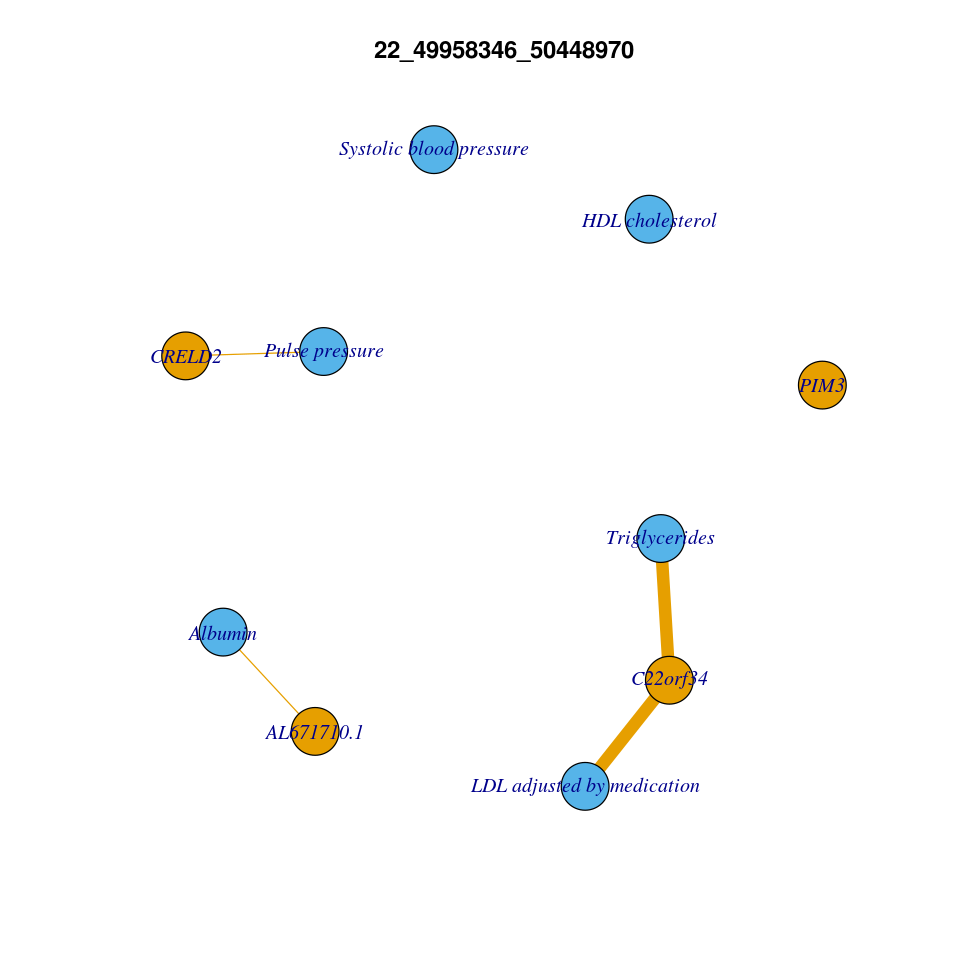

In [24]:
plot_net = function(locus, locus2coloc_list)
{
    indata = locus2coloc_list[[locus]]
    mynet  = indata[["network"]][["network"]]
    
    if(is.null(mynet) == FALSE)
    {
        plot(mynet, 
             edge.width         = E(mynet)$weight2 * 10, 
             edge.color         = as.factor(E(mynet)$type), 
             vertex.shape       = "circle",
             vertex.label       = V(mynet)$name,
             vertex.color       = as.factor(V(mynet)$type),
             vertex.label.font  = 3,
             main               = locus
            )
    }
}



locus = "22_49958346_50448970"
trait2gene2locus[ trait2gene2locus$locus == locus,]

plot_net(locus, locus2coloc_list)


#locus2coloc_list[[locus]]

In [22]:
tail(trait2gene2locus)

,locus,trait,egenes,egenes_n,egenes_tested_n
,<chr>,<chr>,<chr>,<int>,<int>
6634,22_49958346_50448970,continuous-PP-both_sexes-combined_medadj_irnt,,0,4
6635,22_49958346_50448970,continuous-SBP-both_sexes-combined_medadj_irnt,,0,4
6636,22_50599404_51015285,biomarkers-30690-both_sexes-irnt,,0,20
6637,22_50599404_51015285,biomarkers-30780-both_sexes-irnt,,0,20
6638,22_50599404_51015285,continuous-21001-both_sexes-irnt,ENSG00000188130.14_6,1,20
6639,22_50599404_51015285,continuous-LDLC-both_sexes-medadj_irnt,ENSG00000196576.15_6,1,20


In [26]:
fwrite (trait2gene2locus, "pipeline/eqtl.4.finemap_single/input/trait2gene2locus.txt", sep = "\t", col.names = TRUE, row.names = FALSE)
fwrite (locus2trait     , "pipeline/eqtl.4.finemap_single/input/locus2trait.txt"     , sep = "\t", col.names = TRUE, row.names = FALSE)
saveRDS(locus2coloc_list, "pipeline/eqtl.4.finemap_single/input/locus2coloc_list.rds")

In [28]:
nrow(trait2gene2locus[ trait2gene2locus$trait > 0 & trait2gene2locus$egenes_n >  0,])
length(unique(trait2gene2locus[ trait2gene2locus$trait > 0 & trait2gene2locus$egenes_n >  0, "locus"]))


[1] 1559

[1] 595

In [21]:
nrow(loci)

length(unique(trait2gene2locus[ trait2gene2locus$egenes_tested_n >  0, "locus"]))
length(unique(trait2gene2locus[ trait2gene2locus$egenes_n        >  0, "locus"]))
length(unique(locus2trait     [ locus2trait     $trait           >  1 & locus2trait$egenes_n > 0, "locus"]))
length(unique(locus2trait     [ locus2trait     $trait           == 1 & locus2trait$egenes_n > 0, "locus"]))

nrow(trait2gene2locus[ trait2gene2locus$trait > 0 & trait2gene2locus$egenes_n >  0,])
nrow(trait2gene2locus[ trait2gene2locus$trait > 0 & trait2gene2locus$egenes_n == 1,])

table(trait2gene2locus$egenes_tested_n)
table(trait2gene2locus$egenes_n)

table(locus2trait$trait)
table(locus2trait$egenes_n)

table(locus2trait[,c("trait", "egenes_n")])

[1] 2045

[1] 1530

[1] 595

[1] 482

[1] 113

[1] 1559

[1] 1017


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 861 1057  826  663  410  422  267  261  131  218  144  133  104   87  124   39 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
  35   37   58   50   35   72   10   17   34    4   36   24    8   20   41   20 
  32   34   35   38   40   42   45   46   47   51   53   54   55   57   59   63 
  40    9   14   20   10   11    9   36   12   36    7   11   12   15   17   15 
  64   67   68   72  105  120  181 
  11   13   20   18   15   21   19 


   0    1    2    3    4    5    6    7    8    9   10   11   12 
5080 1017  316  102   58   23   19   11    7    2    2    1    1 


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
858 298 212 191 129  87  73  56  30  30  23  17  12   5   8   6   2   2   2   2 
 21 
  2 


   0    1    2    3    4    5    6    7    8    9   10   11   12 
1450  389  116   37   23    6   10    6    3    2    1    1    1 

     egenes_n
trait   0   1   2   3   4   5   6   7   8   9  10  11  12
   1  745  88  17   5   0   0   2   0   0   1   0   0   0
   2  227  57  10   4   0   0   0   0   0   0   0   0   0
   3  159  43   9   1   0   0   0   0   0   0   0   0   0
   4  120  51  11   5   3   0   1   0   0   0   0   0   0
   5   76  34  17   0   1   0   0   1   0   0   0   0   0
   6   41  28   9   4   3   1   0   0   0   1   0   0   0
   7   31  19  14   4   2   1   0   2   0   0   0   0   0
   8   18  20   9   3   3   1   1   1   0   0   0   0   0
   9    9  13   2   4   0   1   0   0   1   0   0   0   0
   10   6  13   5   0   5   0   1   0   0   0   0   0   0
   11   4   7   5   3   1   0   2   0   1   0   0   0   0
   12   6   5   4   0   1   1   0   0   0   0   0   0   0
   13   4   4   2   0   0   1   0   0   1   0   0   0   0
   14   1   2   0   1   0   0   1   0   0   0   0   0   0
   15   1   2   0   1   2   0   1   0   0   0   1   0   0
   16   1   1   2   0   1   0   0   1   0   0   0   0   0


,locus,trait,egenes_n
,<chr>,<int>,<int>
19,1_145280176_145827683,4,1
26,1_15816714_16270903,4,0
28,1_161310521_161994280,4,3
41,1_172089764_172553953,4,1
47,1_181948703_182460632,4,0
48,1_182869010_183215341,4,0
52,1_192871539_193506261,4,1
55,1_196248779_197362184,4,1
57,1_198764027_199138043,4,0


,locus,trait,egenes,egenes_n,egenes_tested_n
,<chr>,<chr>,<chr>,<int>,<int>
3435,8_145407086_145662032,continuous-102-both_sexes-irnt,ENSG00000170727.7; ENSG00000188686.2,2,10
3436,8_145407086_145662032,continuous-DBP-both_sexes-combined_medadj_irnt,ENSG00000170727.7,1,10
3437,8_145407086_145662032,continuous-MAP-both_sexes-combined_medadj_irnt,ENSG00000170727.7,1,10
3438,8_145407086_145662032,continuous-SBP-both_sexes-combined_medadj_irnt,ENSG00000170727.7,1,10


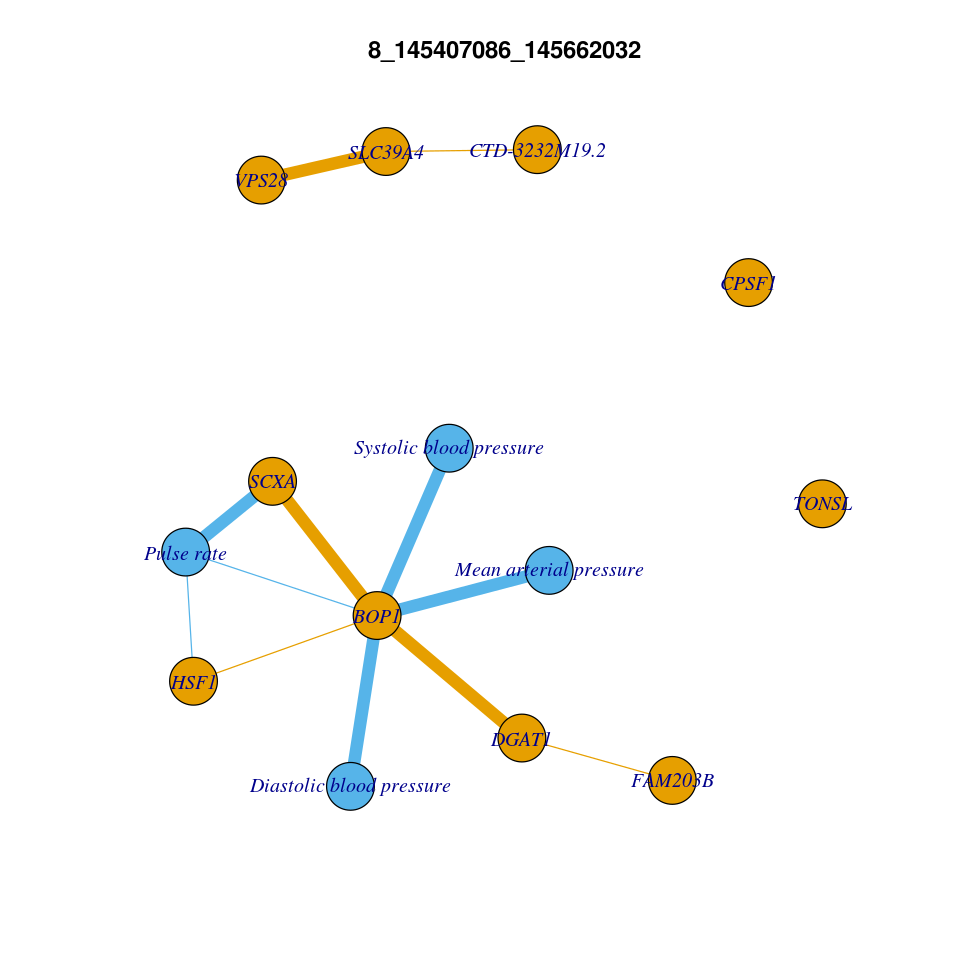

In [247]:
plot_net = function(locus, locus2coloc_list)
{
    indata = locus2coloc_list[[locus]]
    mynet  = indata[["network"]][["network"]]
    
    if(is.null(mynet) == FALSE)
    {
        plot(mynet, 
             edge.width         = E(mynet)$weight2 * 10, 
             edge.color         = as.factor(E(mynet)$type), 
             vertex.shape       = "circle",
             vertex.label       = V(mynet)$name,
             vertex.color       = as.factor(V(mynet)$type),
             vertex.label.font  = 3,
             main               = locus
            )
    }
}

locus2trait[ locus2trait$trait == 4,]

locus = "8_145407086_145662032"

trait2gene2locus[ trait2gene2locus$locus == locus,]

plot_net(locus, locus2coloc_list)


In [188]:
locus2trait
trait2gene2locus

locus,trait
<chr>,<int>
1_106956847_107177386,2
1_107414107_107727697,2
1_107783043_108102360,1
1_108663785_108863785,1
1_108920060_110727340,16
1_10970919_11460957,2
1_110908560_111108560,1
1_111152378_111478354,1
1_112110722_112558893,3


locus,trait,egenes,egenes_n
<chr>,<chr>,<chr>,<int>
1_965800_2544414,biomarkers-30600-both_sexes-irnt,ENSG00000205090.9_5; ENSG00000224870.7_8,2
1_965800_2544414,biomarkers-30680-both_sexes-irnt,,0
1_965800_2544414,biomarkers-30760-both_sexes-irnt,,0
1_965800_2544414,continuous-21001-both_sexes-irnt,ENSG00000189339.12_5; ENSG00000189409.14_7; ENSG00000215790.7_7; ENSG00000215914.4_3; ENSG00000227775.3_6; ENSG00000228594.4_8; ENSG00000272004.1_6,7
1_965800_2544414,continuous-MAP-both_sexes-combined_medadj_irnt,ENSG00000008130.15_5; ENSG00000215790.7_7; ENSG00000227775.3_6,3
1_965800_2544414,continuous-PP-both_sexes-combined_medadj_irnt,ENSG00000189409.14_7; ENSG00000215914.4_3; ENSG00000227775.3_6; ENSG00000228594.4_8,4
1_965800_2544414,continuous-SBP-both_sexes-combined_medadj_irnt,ENSG00000008130.15_5; ENSG00000215790.7_7; ENSG00000227775.3_6,3
1_2592477_2853372,continuous-21001-both_sexes-irnt,,0
1_2884087_3089456,phecode-411.2-both_sexes,,0


,chrom,from,to,ids,locus,size
,<int>,<int>,<int>,<chr>,<chr>,<int>
1_965800_2544414,1,965800,2544414,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_965800_2544414,1578614
1_2592477_2853372,1,2592477,2853372,continuous-21001-both_sexes-irnt,1_2592477_2853372,260895
1_2884087_3089456,1,2884087,3089456,phecode-411.2-both_sexes,1_2884087_3089456,205369
1_3205016_3441796,1,3205016,3441796,"continuous-DBP-both_sexes-combined_medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_3205016_3441796,236780
1_6148182_6406912,1,6148182,6406912,"continuous-102-both_sexes-irnt,continuous-PP-both_sexes-combined_medadj_irnt",1_6148182_6406912,258730
1_6544723_6879372,1,6544723,6879372,"continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_6544723_6879372,334649
1_7622595_7901372,1,7622595,7901372,"continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt",1_7622595_7901372,278777
1_8290051_8995448,1,8290051,8995448,"continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_8290051_8995448,705397
1_9235173_9556513,1,9235173,9556513,"biomarkers-30600-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_9235173_9556513,321340


# OLD

In [17]:
get_assoc_by_locus = function(locus, loci, loci2study, coloc_gwas, coloc_eqtl)
{
    traits         = unlist(strsplit(loci[locus, "ids"], ","))
    coloc_gwas     = coloc_gwas[ coloc_gwas$locus == locus & coloc_gwas$gwas %in% traits,]
    transcript_ids = sort(unique(coloc_gwas$transcript_id))
    coloc_eqtl     = coloc_eqtl[ coloc_eqtl$transcript_id1 %in% transcript_ids & coloc_eqtl$transcript_id2 %in% transcript_ids,]
    
    
    if((nrow(coloc_gwas) > 0) & (nrow(coloc_eqtl) > 0))
    {
        coloc_gwas_all = aggregate(PP.H4.abf ~ gwas      + gene_id  + gene_name                         , data = coloc_gwas, FUN = max)
        coloc_eqtl_all = aggregate(PP.H4.abf ~             gene_id1 + gene_name1 + gene_id2 + gene_name2, data = coloc_eqtl, FUN = max)

        coloc_gwas_all = coloc_gwas_all[order(coloc_gwas_all$gwas    , coloc_gwas_all$gene_id ),]
        coloc_eqtl_all = coloc_eqtl_all[order(coloc_eqtl_all$gene_id1, coloc_eqtl_all$gene_id2),]

        coloc_eqtl_all = coloc_eqtl_all[ coloc_eqtl_all$gene_id1 != coloc_eqtl_all$gene_id2,]

        message(paste(locus, 
                      paste("traits", length(traits), sep = " = "),
                      paste("Traits that colocalize with eGenes", length(unique(coloc_gwas_all$gwas   )), sep = " = "),
                      paste("eGenes that colocalize with traits", length(unique(coloc_gwas_all$gene_id)), sep = " = "),
                      paste("eGenes that colocalize in locus"   , length(unique(c(as.matrix(unique(coloc_eqtl_all[ coloc_eqtl_all$gene_id1 %in% unique(coloc_gwas_all$gene_id) | coloc_eqtl_all$gene_id2 %in% unique(coloc_gwas_all$gene_id),c("gene_id1", "gene_id2")]))))), sep = " = "),
                      sep = "\n"
                     ))
    }else
    {
        coloc_gwas_all = NULL
        coloc_eqtl_all = NULL
    }
    
    return(list(gwas       = traits, 
                coloc_gwas = coloc_gwas_all, 
                coloc_eqtl = coloc_eqtl_all
               ))
}

#locus = "1_965800_2544414"
locus = "14_64512858_64914311"
#locus = "1_6148182_6406912"
x = get_assoc_by_locus(locus, loci, loci2study, coloc_gwas08, coloc_eqtl08)
   
x

14_64512858_64914311
traits = 1
Traits that colocalize with eGenes = 1
eGenes that colocalize with traits = 1
eGenes that colocalize in locus = 0



,gwas,gene_id,gene_name,PP.H4.abf
,<chr>,<chr>,<chr>,<dbl>
1,icd10-I48-both_sexes,ENSG00000054654.18_8,SYNE2,0.9833449
gene_id1,gene_name1,gene_id2,gene_name2,PP.H4.abf
<chr>,<chr>,<chr>,<chr>,<dbl>


In [18]:
str(coloc_gwas)

'data.frame':	125013 obs. of  33 variables:
 $ transcript_id                               : chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000460.17_7" ...
 $ gene_id                                     : chr  "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000460.17_7" ...
 $ gene_name                                   : chr  "SCYL3" "SCYL3" "SCYL3" "C1orf112" ...
 $ phenotype                                   : chr  "rna" "rna" "rna" "rna" ...
 $ nsnps                                       : int  1513 1513 1513 1933 1933 1933 994 994 994 994 ...
 $ PP.H0.abf                                   : num  1.56e-07 1.58e-07 8.71e-03 1.06e-02 1.89e-07 ...
 $ PP.H1.abf                                   : num  0.387 0.39 0.378 0.462 0.47 ...
 $ PP.H2.abf                                   : num  2.38e-07 2.41e-07 1.33e-02 1.13e-02 2.01e-07 ...
 $ PP.H3.abf                                   : num  0.592 0.597 0.579 0.491 0.499 .

In [19]:
str(coloc_eqtl)


'data.frame':	464870 obs. of  25 variables:
 $ gene_id1      : chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000460.17_7" "ENSG00000000971.16_4" ...
 $ gene_name1    : chr  "DPM1" "SCYL3" "C1orf112" "CFH" ...
 $ transcript_id2: chr  "ENST00000371588.9_2" "ENST00000367771.11_4" "ENSG00000000457.14_7" "ENST00000367429.9_2" ...
 $ gene_id2      : chr  "ENSG00000000419.12_6" "ENSG00000000457.14_7" "ENSG00000000457.14_7" "ENSG00000000971.16_4" ...
 $ gene_name2    : chr  "DPM1" "SCYL3" "SCYL3" "CFH" ...
 $ nsnps         : int  2011 2835 2683 1293 1293 2493 2493 2493 2493 1957 ...
 $ PP.H0.abf     : num  3.94e-01 1.09e-02 1.33e-01 1.26e-06 1.87e-07 ...
 $ PP.H1.abf     : num  4.80e-01 3.02e-01 2.55e-01 3.59e-05 3.70e-05 ...
 $ PP.H2.abf     : num  0.04721 0.02097 0.15877 0.03396 0.00503 ...
 $ PP.H3.abf     : num  0.0576 0.582 0.3039 0.9649 0.9944 ...
 $ PP.H4.abf     : num  0.021105 0.084104 0.149402 0.001079 0.000569 ...
 $ type1         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ typ

In [20]:
str(loci)
str(loci2study)

'data.frame':	2045 obs. of  6 variables:
 $ chrom: int  1 1 1 1 1 1 1 1 1 1 ...
 $ from : int  965800 2592477 2884087 3205016 6148182 6544723 7622595 8290051 9235173 9830927 ...
 $ to   : int  2544414 2853372 3089456 3441796 6406912 6879372 7901372 8995448 9556513 10934579 ...
 $ ids  : chr  "biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-2"| __truncated__ "continuous-21001-both_sexes-irnt" "phecode-411.2-both_sexes" "continuous-DBP-both_sexes-combined_medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-bot"| __truncated__ ...
 $ locus: chr  "1_965800_2544414" "1_2592477_2853372" "1_2884087_3089456" "1_3205016_3441796" ...
 $ size : int  1578614 260895 205369 236780 258730 334649 278777 705397 321340 1103652 ...
'data.frame':	2045 obs. of  27 variables:
 $ biomarkers-30600-both_sexes-irnt              : int  1 0 0 0 0 0 0 0 1 0 ...
 $ biomarkers-30680-both_sexes-irnt              : int  1 0 0 0 0 0 0 0 

In [21]:
head(loci)

,chrom,from,to,ids,locus,size
,<int>,<int>,<int>,<chr>,<chr>,<int>
1_965800_2544414,1,965800,2544414,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_965800_2544414,1578614
1_2592477_2853372,1,2592477,2853372,continuous-21001-both_sexes-irnt,1_2592477_2853372,260895
1_2884087_3089456,1,2884087,3089456,phecode-411.2-both_sexes,1_2884087_3089456,205369
1_3205016_3441796,1,3205016,3441796,"continuous-DBP-both_sexes-combined_medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_3205016_3441796,236780
1_6148182_6406912,1,6148182,6406912,"continuous-102-both_sexes-irnt,continuous-PP-both_sexes-combined_medadj_irnt",1_6148182_6406912,258730
1_6544723_6879372,1,6544723,6879372,"continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",1_6544723_6879372,334649
